# Test for a simple regression problem

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

import sys
import twodlearn as tdl
from twodlearn.datasets.Batch_generator import *

## 1. Create Dataset

In [2]:
train_X= np.expand_dims(np.linspace(0,10,100), -1)
train_y= np.sin(train_X)

test_X= np.expand_dims(np.linspace(0,10,1000), -1)
test_y= np.sin(test_X)

n_features= 1

print(train_X.shape)
print(train_y.shape)

(100, 1)
(100, 1)


#### normalization

In [3]:
std_data= np.std(train_X, 0)
mean_data= np.mean(train_X, 0)

for i in range(n_features):
    train_X[:,i]= (train_X[:,i]-mean_data[i])/std_data[i]
    test_X[:,i]= (test_X[:,i]-mean_data[i])/std_data[i]
print(np.std(train_X,0))
print(np.std(test_X,0))

[1.]
[0.99104005]


## 2. Batch Generators

In [4]:
batch_size = train_X.shape[0] #50
batch_size_test= test_X.shape[0]

## 2. Define the Model

In [5]:
sess = tf.InteractiveSession()

In [6]:
# Network parameters
n_inputs= n_features

# for dropout
drop_prob = tf.placeholder(dtype=tf.float32)

# Define MLP Net
mlp_net= tdl.stacked.StackedLayers( 
    layers=[tdl.dense.AffineLayer(units=30),
            tf.keras.layers.Activation(tf.sigmoid),
            lambda x: tf.nn.dropout(x, keep_prob=1-drop_prob),
            tdl.dense.AffineLayer(units=1)])


# Define train setup
inputs = tf.placeholder(shape=(None, n_features), 
                        dtype=tf.float32)
outputs = mlp_net(inputs)
train= tdl.core.SimpleNamespace(
    inputs=inputs, 
    outputs=tf.convert_to_tensor(outputs),
    loss=tdl.losses.L2Loss(outputs))
# Define test setup
test=tdl.core.SimpleNamespace(
    outputs=tf.convert_to_tensor(mlp_net(inputs)),
    inputs=inputs)


# Optimizer.
optimizer = tf.train.AdamOptimizer(0.01).minimize(tf.convert_to_tensor(train.loss)) #0.001

## 3. Train the model

In [7]:
num_steps = 5000
n_logging = 100
n_test_logg = 10

tf.global_variables_initializer().run()
print('Initialized')

mean_loss= 0
train_accuracy= 0
for step in range(num_steps):
    batch_X= train_X
    batch_y= train_y
    
        
    feed_dict = {train.inputs : batch_X, train.loss.labels : batch_y, drop_prob:0.0}
    ops = [optimizer, tf.convert_to_tensor(train.loss), 
           tf.convert_to_tensor(train.outputs)]
    _, l, train_pred = sess.run(ops,feed_dict=feed_dict)
    mean_loss += l    
    
    if step%n_logging == 0:                
        # test
        pred = test.outputs.eval(feed_dict={test.inputs: test_X, drop_prob: 0.0})
            
        test_error = np.sum( np.power(pred-test_y, 2.0) )/2.0
        
        # print            
        print(step, ' | test:', test_error, ' | loss:', mean_loss/n_logging)
        mean_loss= 0
mean_loss = mean_loss/n_logging

Initialized
0  | test: 246.2093090558031  | loss: 0.005947428941726685
100  | test: 219.6865858843763  | loss: 0.4428731468319893
200  | test: 112.09909706073499  | loss: 0.372265647649765
300  | test: 48.20053209190576  | loss: 0.1472421956807375
400  | test: 28.662019017241505  | loss: 0.07948238089680672
500  | test: 20.129014761206378  | loss: 0.05185286171734333
600  | test: 11.078645423670949  | loss: 0.03413072001188994
700  | test: 3.6232035736120776  | loss: 0.01524580042809248
800  | test: 1.1367405281045257  | loss: 0.004737295375671238
900  | test: 0.5004120705198278  | loss: 0.0017129029612988234
1000  | test: 0.2726959797551356  | loss: 0.000827334148925729
1100  | test: 0.16895743035034247  | loss: 0.00047384879755554723
1200  | test: 0.113658527538886  | loss: 0.00030230116681195796
1300  | test: 0.08019556120785833  | loss: 0.00020608294173143804
1400  | test: 0.05824796117105853  | loss: 0.00014610615296987818
1500  | test: 0.04323391013958667  | loss: 0.0001063355687

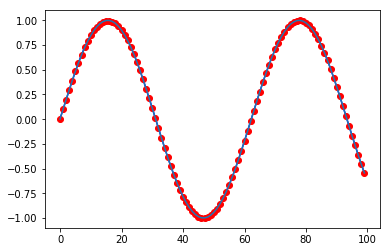

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

pred = train.outputs.eval(feed_dict={train.inputs: train_X, drop_prob: 0.0})

plt.plot(np.arange(pred.shape[0]), pred, 'b')
plt.plot(np.arange(pred.shape[0]), pred, 'ro')

plt.plot(np.arange(train_y.shape[0]), train_y)


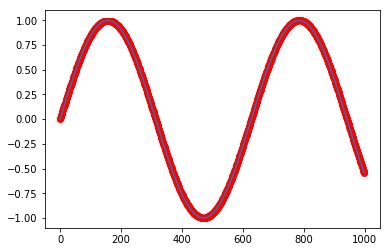

In [9]:
pred = test.outputs.eval(feed_dict={test.inputs: test_X, drop_prob: 0.0})

plt.plot(np.arange(pred.shape[0]), pred, 'b')
plt.plot(np.arange(pred.shape[0]), pred, 'ro')
plt.plot(np.arange(test_y.shape[0]), test_y)


In [10]:
tdl.get_trainable(mlp_net)

[<tf.Variable 'AffineLayer_1/kernel/kernel:0' shape=(30, 1) dtype=float32>,
 <tf.Variable 'AffineLayer/kernel/kernel:0' shape=(1, 30) dtype=float32>,
 <tf.Variable 'AffineLayer_1/bias/bias:0' shape=(1,) dtype=float32>,
 <tf.Variable 'AffineLayer/bias/bias:0' shape=(30,) dtype=float32>]

In [11]:
assert (test_error<0.5) and ((mean_loss<0.001)), "Error of mlp higher than expected"
#assert (sorted([w.name for w in tdl.get_trainable(mlp_net)]) ==
#        sorted(['MlpNet/layers/DenseLayer/weights/W:0',
#                'MlpNet/layers/AffineLayer/weights/W:0', 
#                'MlpNet/layers/AffineLayer/bias/b:0',
#                'MlpNet/layers/DenseLayer/bias/b:0'])), 'Naming convention incorrect'